In [19]:
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 27.0 MB/s eta 0:00:00


In [4]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import konlpy.tag

In [5]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [6]:
okt = konlpy.tag.Okt()

In [21]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/쿠키닷컴/성지순례 댓글 분석-중복제거.csv", encoding="utf-8")
df

,Unnamed: 0,date,year,prep
0,1,2001-07-17,2001,복숭아 송료 포함 가격
1,2,2001-07-17,2001,정추영 재미없다
2,3,2001-07-17,2001,재밋스신 분이시네요 한참 웃엇습니
3,4,2001-07-17,2001,안사 안사
4,5,2001-07-17,2001,삼하게 그대로 찍지 뜯어 먹고 찍었네 가여
...,...,...,...,...
19376,19377,2022-11-22,2022,ParticleEffe 색스
19377,19378,2022-11-22,2022,NaN
19378,19379,2022-11-25,2022,성지순례 왔습니다
19379,19380,2022-12-05,2022,최초 성지 순례 왔습니다 이번 친 jlpt n 급 최소 점 나와서 과락없 합격 할 ...


In [8]:
df.dropna()

,Unnamed: 0,date,year,prep
0,1,2001-07-17,2001,복숭아 송료 포함 가격
1,2,2001-07-17,2001,정추영 재미없다
2,3,2001-07-17,2001,재밋스신 분이시네요 한참 웃엇습니
3,4,2001-07-17,2001,안사 안사
4,5,2001-07-17,2001,삼하게 그대로 찍지 뜯어 먹고 찍었네 가여
...,...,...,...,...
19375,19376,2022-11-14,2022,헉
19376,19377,2022-11-22,2022,ParticleEffe 색스
19378,19379,2022-11-25,2022,성지순례 왔습니다
19379,19380,2022-12-05,2022,최초 성지 순례 왔습니다 이번 친 jlpt n 급 최소 점 나와서 과락없 합격 할 ...


In [9]:
%matplotlib inline

def dwc(origin_df, start_date, end_date):
    
    query = origin_df[(origin_df.date >= start_date) & (origin_df.date <= end_date)]
    
    stopws = {'의', '여', '조', '몇', '개', '사', '주', '상', '단', '랑', '년', '인', '엔', '래', '써', \
          '초', '걸', '동', '등', '짱', '더', '서', '넌', '못', '면', '군', '닷', '적', '응', '원', \
          '기', '난', '나', '님', '네', '왜', '끝', '눈', '만', '나도', '시', '종', '징', '데', '참', \
          '운', '미', '입니다', '깔', '고', '것', '워', '라', '가', '이', '은', '들', '는', '좀', '잘', \
          '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '을', '이다', '게', '있다', \
          '되다', '다', '대', '현', '내', '노', '중', '아', '제', '요', '없다', '거', '안', '수', '저', \
          '하', '에서', 'ㅡ', '야', '이오', '되게', 'ㅋㅋㅋ', '지금', '위', '거', '이제', '전', '맛', \
          '번', '어디', '다시', '일', '집', '알', '글', '혹시', '정말', '여기', '꼭', '하나', '이상', \
          '짜', '허이', '허', '월', '해', '두', '_', '분', '로', '옆', '저', '제', '까지', '탁탁', '갤', \
          '환', '장', '봉', '다나'}

    q = query[['prep', 'date']].dropna()
    q.columns = ['textsum', 'date']
    
    q.index = range(len(q))
    
    q['preprocess'] = q.textsum.apply(lambda text : " ".join(parser.morphs(text)))
    cnt = Counter(word for line in q.preprocess for word in line.split())
    print(len(q))
    
    filtered_cnt = {word: freq for word, freq in cnt.items() if freq >= 30 and len(word) >= 2}

    font_path = '/content/NanumBarunGothic.ttf'
    wc = WordCloud(
                   font_path=font_path,
                   stopwords=stopws,
                   width=1200 , height=600,
                   background_color="white").generate_from_frequencies(filtered_cnt)

    plt.figure(figsize=(15,6))
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')
    plt.show()

    # Convert the filtered frequency count dictionary to a Pandas DataFrame
    filtered_cnt_df = pd.DataFrame(list(filtered_cnt.items()), columns=['word', 'frequency'])
    
    # Sort the words by frequency in descending order
    filtered_cnt_df.sort_values(by='frequency', ascending=False, inplace=True)
    
    # Display the frequency values as a table
    print(filtered_cnt_df)

In [10]:
def fw(origin_df, start_date, end_date):
    
    query = origin_df[(origin_df.date >= start_date) & (origin_df.date <= end_date)]
    
    q = query[['prep', 'date']].dropna()
    q.columns = ['text', 'date']
    # q2 = query[['Review Title', 'Date_Time']].dropna()    
    # q2.columns = ['Reviews', 'Date_Time']
    
    # q = q1.append(q2)
    q.index = range(len(q))
    
    # q['preprocess'] = q.textsum.apply(lambda text : " ".join(parser.morphs(text)))
    q['preprocess'] = q.text.apply(lambda text : " ".join(okt.morphs(text)))
    cnt = Counter(word for line in q.preprocess for word in line.split())

    filtered_cnt = {word: freq for word, freq in cnt.items() if freq > 50 and len(word) >= 2}
    
    print(len(q))
    print(cnt)

3360


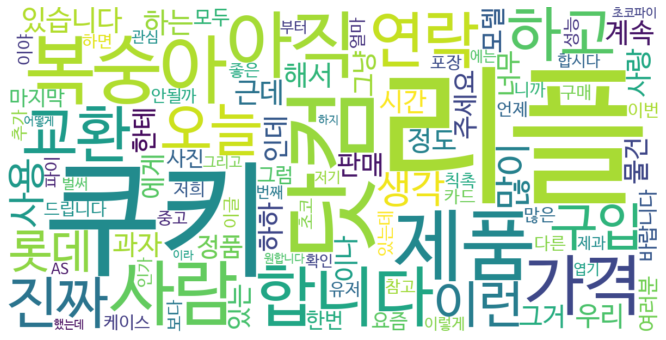

   word  frequency
27   리플        677
13   쿠키        461
71   닷컴        243
10   제품        156
0   복숭아        140
..  ...        ...
65  했는데         30
93   이라         30
30   AS         30
50   하지         30
28   엽기         30

[99 rows x 2 columns]


In [ ]:
dwc(df, '2001-07-17', '2001-12-31')

In [ ]:
fw(df, '2001-07-17', '2001-12-31')

3360
Counter({'리플': 677, '쿠키': 461, '닷컴': 243, '제품': 156, '복숭아': 140, '아직': 131, '사람': 125, '합니다': 118, '가격': 117, '그': 103, '연락': 101, '니': 100, '교환': 99, '하고': 98, '컴': 87, '오늘': 85, '진짜': 85, '구입': 82, '이런': 77, '롯데': 77, '구': 75, '말': 74, '할': 72, '생각': 71, '사용': 70, '많이': 67, '있습니다': 67, '넘': 67, '하는': 65, '때': 65, '근데': 65, '음': 63, '우리': 62, '계속': 62, '정도': 61, '해서': 60, '과자': 59, '하하': 59, '사랑': 57, '인데': 55, '시간': 54, '판매': 54, '그거': 53, '물건': 52, '따': 52, '뭐': 52, '주세요': 50, '정품': 50, '이나': 50, '또': 50, '너무': 49, '돈': 49, '그냥': 48, '달': 48, '한테': 47, '있는': 47, '모델': 47, '에게': 47, '마지막': 47, '한번': 46, '맨': 46, '사진': 45, '너': 45, '여러분': 44, '냐': 44, '염': 42, '그럼': 41, '곳': 41, '헉': 41, '요즘': 41, '모두': 40, '바랍니다': 40, '드립니다': 40, '케이스': 39, '다른': 39, '칙촉': 38, '있는데': 38, '이야': 38, '오': 37, '보다': 37, '바': 37, '우': 36, '언제': 36, '구매': 36, '카드': 36, '배': 36, '째': 36, '포장': 35, '유저': 35, '용': 35, '얼마': 35, '많은': 35, '된': 35, '이글': 35, '초코': 34, '이번': 34, '저희': 34, '죠': 34, '니까': 34,

3746


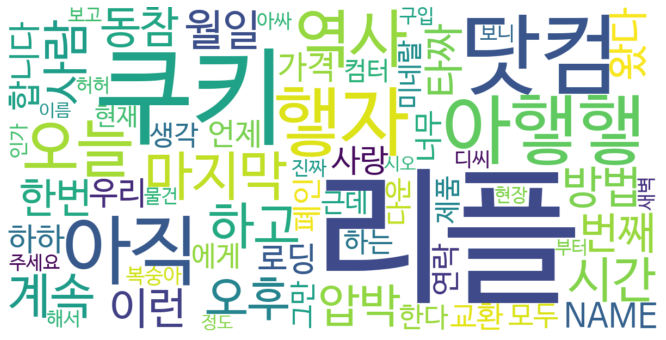

In [ ]:
dwc(df, '2002-01-01', '2002-12-31')

In [ ]:
fw(df, '2002-01-01', '2002-12-31')

3746
Counter({'리플': 927, '쿠키': 410, '닷컴': 275, '아직': 197, '아햏햏': 197, '햏자': 195, '역사': 129, '오늘': 122, '컴': 97, '마지막': 91, '하고': 82, '그': 79, '시간': 77, '계속': 73, '오후': 70, '사람': 70, '달': 69, '압박': 67, '니': 64, '방법': 62, '동참': 61, '이런': 60, '번째': 60, '오': 59, '월일': 59, '째': 55, '타짜': 55, '한번': 53, '왔다': 53, '우': 52, 'NAME': 52, '본': 52, '합니다': 51, '로딩': 51, '할': 51, '감': 50, '때': 50, '가격': 50, '우리': 50, '하하': 49, '사랑': 49, '말': 47, '또': 46, '언제': 46, '폐인': 46, '음': 46, '교환': 45, '연락': 44, '곳': 44, '햏': 44, '너무': 43, '모두': 41, '에게': 40, '뭐': 38, '한다': 38, '생각': 38, '하는': 38, '냐': 37, '다운': 37, '그만': 37, '구': 37, '제품': 37, '근데': 37, '컴터': 36, '미네랄': 36, '넘': 35, '현재': 35, '복숭아': 35, '헉': 34, '흠': 34, '디씨': 34, '아싸': 33, '진짜': 33, '보니': 33, '구입': 33, '인가': 33, '주세요': 32, '줄': 32, '보고': 32, '날': 32, '허허': 32, '해서': 32, '물건': 32, '따': 32, '새벽': 32, '부터': 31, '현장': 31, '정도': 30, '이름': 30, '시오': 30, '많이': 29, '오전': 29, '쉬운': 29, '드디어': 29, '라오': 29, '좌': 29, '있소': 29, '그냥': 28, '있는': 28, '누가':

5254


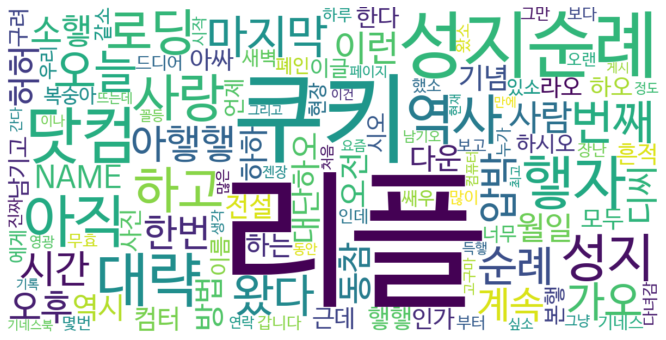

In [ ]:
dwc(df, '2003-01-01', '2003-12-31')

In [ ]:
fw(df, '2003-01-01', '2003-12-31')

5254
Counter({'리플': 1102, '쿠키': 355, '성지순례': 352, '닷컴': 246, '햏': 245, '대략': 224, '햏자': 214, '아직': 207, '역사': 189, '성지': 174, '사랑': 167, '로딩': 160, '하고': 159, '번째': 143, '오늘': 136, '왔다': 133, '마지막': 132, '감': 115, '순례': 112, '가오': 111, '아햏햏': 109, '압박': 109, '시간': 107, '그': 102, '한번': 99, '계속': 98, '이런': 91, '오후': 89, '곳': 87, '사람': 87, '달': 86, '때': 85, '소햏': 83, '허허': 82, '째': 82, '말': 82, '동참': 82, '컴': 81, '오': 77, '또': 75, '디씨': 73, '월일': 67, 'NAME': 65, '대단하오': 64, '날': 63, '오전': 63, '방법': 61, '하하': 61, '역시': 61, '다운': 60, '기념': 58, '전설': 57, '할': 57, '컴터': 57, '쏘': 56, '하는': 56, '햏햏': 56, '음': 54, '아싸': 54, '바': 52, '모두': 51, '하오': 51, '인가': 50, '한다': 50, '너': 49, '근데': 49, '사진': 49, '라오': 48, '남기고': 48, '흔적': 48, '하시오': 47, '따': 47, '이글': 46, '언제': 46, '이름': 46, '본햏': 46, '시오': 46, '구려': 45, '복숭아': 45, '새벽': 45, '플': 44, '너무': 43, '있소': 43, '넘': 43, '폐인': 43, '우리': 43, '본': 42, '같소': 42, '줄': 42, '에게': 42, '현장': 42, '쌔우': 41, '장': 41, '드디어': 40, '니': 40, '으': 40, '우': 39, '기네스'

2411


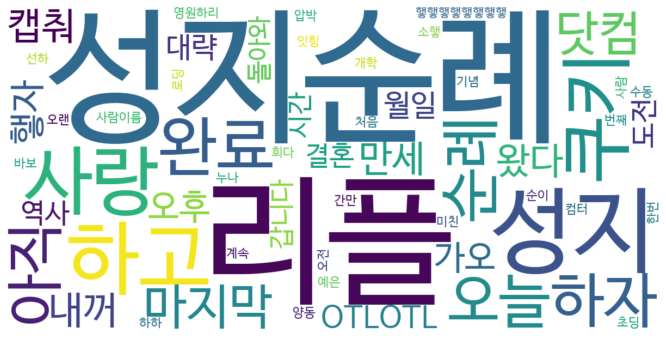

In [ ]:
dwc(df, '2004-01-01', '2004-12-31')

In [ ]:
fw(df, '2004-01-01', '2004-12-31')

2411
Counter({'성지순례': 555, '리플': 513, '성지': 166, '하고': 122, '사랑': 105, '쿠키': 100, '완료': 87, '하자': 85, '순례': 85, '아직': 81, '오늘': 79, '마지막': 72, '닷컴': 71, '햏': 70, '내꺼': 70, '캡춰': 66, '플': 65, '만세': 64, '왔다': 64, '햏자': 60, '감': 59, '오후': 56, '가오': 55, 'OTLOTL': 55, '월일': 53, '대략': 50, '도전': 49, '컴': 49, '또': 47, '역사': 46, '때': 46, '결혼': 46, '곳': 43, '갑니다': 43, '만': 43, '시간': 42, '그': 41, '돌아와': 41, '햏햏햏햏햏햏햏햏': 40, '순이': 40, '누나': 40, '달': 39, '로딩': 39, '사람': 38, '영': 38, '초딩': 37, '선하': 37, '예은': 37, '한번': 36, '압박': 35, '덕': 35, '오랜': 34, '번째': 34, '양동': 34, '사람이름': 34, '수동': 34, '잇힝': 33, '오전': 33, '하하': 33, '미친': 33, '바보': 33, '희다': 33, '처음': 32, '날': 32, '소햏': 32, '임': 32, '컴터': 31, '계속': 30, '간만': 30, '기념': 30, '영원하리': 30, '개학': 30, '한다': 29, '오': 29, '아햏햏': 29, '언제': 29, '군대': 28, '후': 28, '정도': 28, '역시': 28, '된': 28, '많이': 27, '보고': 27, '만에': 27, '니': 26, '새벽': 26, '토끼': 26, '퉤': 26, '합니다': 25, '영광': 25, '인가': 24, '하는': 24, '뜨는데': 24, '디씨': 23, '말': 23, '첫': 23, '째': 23, 'NAME': 23

In [ ]:
fw(df, '2005-01-01', '2010-12-31')

2526
Counter({'성지순례': 871, '성지': 285, '해주세요': 196, '리플': 180, '쿠키': 129, '순례': 112, '닷컴': 86, '하고': 80, '디씨': 75, '때': 65, '오늘': 64, '아직': 57, '갑니다': 55, '즐': 53, '왔습니다': 53, '개독교': 50, '곳': 49, '오랜': 48, '컴': 46, '왔다': 43, '수능': 43, '마지막': 42, '사랑': 41, '역사': 41, '날': 40, '사람': 40, '빠삐놈': 40, '처음': 39, '대박': 37, '그': 36, '갤': 35, '에게': 35, '하게': 34, '뭐': 33, '디시': 32, '제발': 31, '합니다': 30, '진짜': 30, '빠삐코': 30, '번째': 29, '올해': 29, '미래': 29, '한번': 28, '간만': 28, '감': 28, '만세': 28, '후': 28, '니': 28, '로딩': 28, '돈': 28, '시험': 28, '하는': 27, '첫': 26, '시간': 26, '마음': 26, '여자친구': 26, '할': 26, '모두': 24, '많이': 24, '오후': 24, '간다': 24, '그리고': 24, '군대': 24, '비': 24, '댓글': 24, '생기': 23, '플': 23, '합격': 23, '만에': 22, '이번': 21, '한다': 21, '대학': 21, '예전': 21, '병신': 21, '그녀': 21, '페이지': 21, '현재': 20, '공부': 20, '너무': 20, '김': 20, '박': 20, '리암': 20, '월일': 19, '또': 19, '이렇게': 19, '시작': 19, '컴퓨터': 18, '오오': 18, '에는': 18, '전설': 18, '박혁': 18, '거세': 18, '이런': 17, '에도': 17, '우리': 17, '말': 17, '대략': 17, '냐': 17, '다운

2526


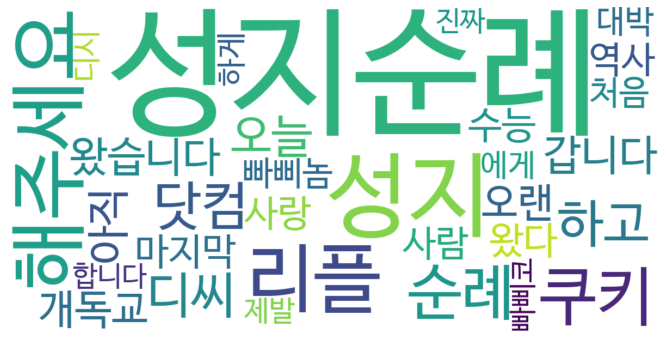

In [ ]:
dwc(df, '2005-01-01', '2010-12-31')

1882


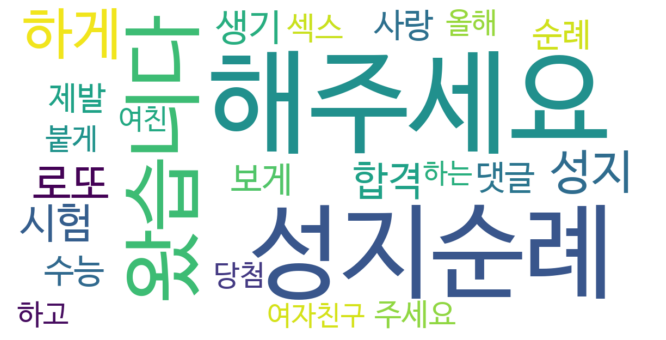

In [ ]:
dwc(df, '2011-01-01', '2023-12-31')

In [ ]:
fw(df, '2011-01-01', '2023-12-31')

1882
Counter({'해주세요': 721, '성지순례': 592, '왔습니다': 336, '하게': 130, '성지': 88, '로또': 73, '시험': 66, '합격': 61, '생기': 55, '보게': 49, '수능': 46, '사랑': 45, '댓글': 45, '순례': 44, '제발': 42, '섹스': 41, '주세요': 38, '붙게': 35, '올해': 34, '하고': 34, '당첨': 34, '여친': 31, '하는': 30, '때': 30, '여자친구': 30, '사람': 29, '가게': 28, '많이': 28, '돈': 27, '소원': 25, '해주세여': 25, '통': 24, '합니다': 23, '왔다': 23, '디시': 22, '살': 22, '뭐': 22, '갑니다': 22, 'the': 22, '대학': 21, '아직': 21, '모두': 21, '이번': 21, '행복하게': 21, '통구이': 21, '고무': 21, '전령': 21, '모든': 20, '쿠키': 20, '좋은': 20, '시발': 20, 'dd': 20, '대박': 19, '오늘': 19, '인생': 19, '이기': 19, '사귀게': 19, '플': 18, '새끼': 18, '이랑': 18, '대박나게': 18, '있게': 18, '니': 17, '해주시': 17, '할': 17, '디씨': 16, '그': 16, '역사': 16, '우리': 16, '첫': 16, '이루어지게': 16, '곳': 15, '최초': 15, '닷컴': 15, '돋긔': 14, '올': 14, '등급': 14, '해주': 14, '애': 13, '기원': 13, '씨발': 13, '보고': 13, '한다': 13, '벌게': 13, '맞게': 13, '가족': 13, 'a': 13, '시간': 13, '미래': 13, '리플': 12, '새': 12, '받게': 12, '아햏햏': 12, '오': 12, '병신': 12, '취업': 12, '환상향': 12, '인

In [11]:
fw(df, '2001-07-17', '2001-12-31')
fw(df, '2002-01-01', '2002-12-31')
fw(df, '2003-01-01', '2003-12-31')
fw(df, '2004-01-01', '2004-12-31')
fw(df, '2005-01-01', '2005-12-31')
fw(df, '2006-01-01', '2006-12-31')
fw(df, '2007-01-01', '2007-12-31')
fw(df, '2008-01-01', '2008-12-31')
fw(df, '2009-01-01', '2009-12-31')
fw(df, '2010-01-01', '2010-12-31')
fw(df, '2011-01-01', '2011-12-31')
fw(df, '2012-01-01', '2012-12-31')
fw(df, '2013-01-01', '2013-12-31')
fw(df, '2014-01-01', '2014-12-31')
fw(df, '2015-01-01', '2015-12-31')
fw(df, '2016-01-01', '2016-12-31')
fw(df, '2017-01-01', '2017-12-31')
fw(df, '2018-01-01', '2018-12-31')
fw(df, '2019-01-01', '2019-12-31')
fw(df, '2020-01-01', '2020-12-31')
fw(df, '2021-01-01', '2021-12-31')
fw(df, '2022-01-01', '2022-12-31')

3360
Counter({'리플': 677, '쿠키': 461, '닷컴': 243, '제품': 156, '복숭아': 140, '아직': 131, '사람': 125, '합니다': 118, '가격': 117, '그': 103, '연락': 101, '니': 100, '교환': 99, '하고': 98, '컴': 87, '오늘': 85, '진짜': 85, '구입': 82, '이런': 77, '롯데': 77, '구': 75, '말': 74, '할': 72, '생각': 71, '사용': 70, '많이': 67, '있습니다': 67, '넘': 67, '하는': 65, '때': 65, '근데': 65, '음': 63, '우리': 62, '계속': 62, '정도': 61, '해서': 60, '과자': 59, '하하': 59, '사랑': 57, '인데': 55, '시간': 54, '판매': 54, '그거': 53, '물건': 52, '따': 52, '뭐': 52, '주세요': 50, '정품': 50, '이나': 50, '또': 50, '너무': 49, '돈': 49, '그냥': 48, '달': 48, '한테': 47, '있는': 47, '모델': 47, '에게': 47, '마지막': 47, '한번': 46, '맨': 46, '사진': 45, '너': 45, '여러분': 44, '냐': 44, '염': 42, '그럼': 41, '곳': 41, '헉': 41, '요즘': 41, '모두': 40, '바랍니다': 40, '드립니다': 40, '케이스': 39, '다른': 39, '칙촉': 38, '있는데': 38, '이야': 38, '오': 37, '보다': 37, '바': 37, '우': 36, '언제': 36, '구매': 36, '카드': 36, '배': 36, '째': 36, '포장': 35, '유저': 35, '용': 35, '얼마': 35, '많은': 35, '된': 35, '이글': 35, '초코': 34, '이번': 34, '저희': 34, '죠': 34, '니까': 34,